# Intialize

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class as Class_sz
import os
import time





cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators and to avoid any ambiguity when comparing with camb. 
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665
}



# Compute linear matter power spectrum

## Method 1: Interpolator

In this method, $P(k,z)$ is obtained by interpolating a $z$ and $k$ grid. 

The number of points in the $k$ dimension is fixed by the emulators settings. 

The number of points in the $z$ dimension is fixed by the use via the parameter `ndim_redshifts`

In [3]:
%%time 
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':'mPk',
'ndim_redshifts': 100
})
classy_sz.initialize_classy_szfast()

CPU times: user 70.9 ms, sys: 4.96 ms, total: 75.8 ms
Wall time: 73.7 ms


In [4]:
z = 0.3
kmin = 1e-3
kmax = 1e1
nks = 500
ks = np.geomspace(kmin,kmax,nks)
pks = classy_sz.pk_lin(ks,z)

[]

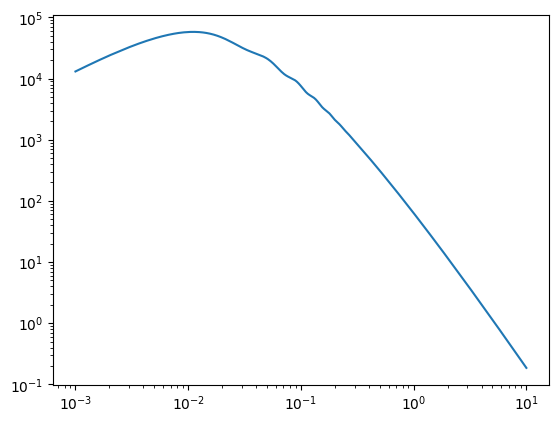

In [5]:
plt.plot(ks,pks)
plt.loglog()

In [6]:
%%time
# let's time it
%timeit -n 100 -r 10 classy_sz.initialize_classy_szfast()

7.86 ms ± 125 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)
CPU times: user 7.92 s, sys: 509 ms, total: 8.43 s
Wall time: 7.86 s


## Method 2: On the $k$-grid

In this method, we first initialize the computation and then compute the pks.

The advantage of this method is that we don't go through the Pk interpolator at each evaluation when we call 
`classy_sz.get_pkl_at_z`

In [7]:
%%time
# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':'mPk',
})
classy_sz.initialize_classy_szfast()

CPU times: user 67.3 ms, sys: 4.11 ms, total: 71.4 ms
Wall time: 69.8 ms


In [8]:
%%time
z = 0.3
pks,ks = classy_sz.get_pkl_at_z(z,params_values_dict = cosmo_params)

CPU times: user 3.33 ms, sys: 4.85 ms, total: 8.18 ms
Wall time: 4.73 ms


[]

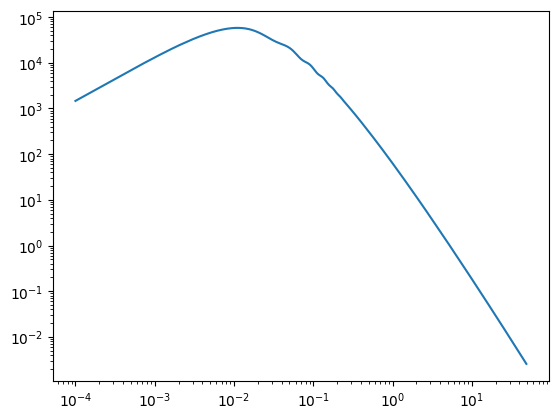

In [9]:
plt.plot(ks,pks)
plt.loglog()

In [11]:
# let's time it 
%timeit -n 500 -r 10 classy_sz.get_pkl_at_z(z,params_values_dict = cosmo_params)

258 μs ± 44.7 μs per loop (mean ± std. dev. of 10 runs, 500 loops each)


# Compute with Jax

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from classy_sz import Class as Class_sz
import jax.numpy as jnp
import jax

In [13]:
%%time
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators and to avoid any ambiguity when comparing with camb.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':'mPk',
'jax': 1
})
classy_sz.initialize_classy_szfast()

CPU times: user 1.07 s, sys: 97 ms, total: 1.17 s
Wall time: 933 ms


In [15]:
%%time
z = 0.3
pks,ks = classy_sz.get_pkl_at_z(z,params_values_dict = cosmo_params)

CPU times: user 6.99 ms, sys: 3.89 ms, total: 10.9 ms
Wall time: 3.96 ms


[]

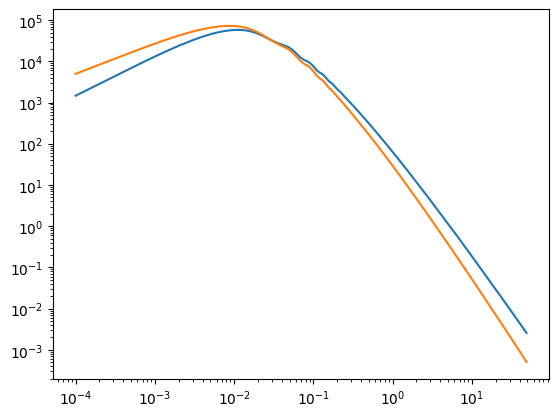

In [16]:
plt.plot(ks,pks)
cosmo_params.update({'H0':82,'n_s':0.75})
pks,ks = classy_sz.get_pkl_at_z(z,params_values_dict = cosmo_params)
plt.plot(ks,pks)
plt.loglog()

## Get pk at z and k

In [12]:
# import jax.scipy as jscipy
# Define the interpolating function
def get_pkl_at_z_and_k(z,k,cosmo_params):    
    pks,ks = classy_sz.get_pkl_at_z(z,params_values_dict = cosmo_params)
    
    # Interpolate in log-log space
    log_ks = jnp.log(ks)
    log_pks = jnp.log(pks.flatten())
    
    log_k = jnp.log(k)
    
    log_pk = jnp.interp(log_k,log_ks, log_pks)
    return jnp.exp(log_pk)  # Return the interpolated result in linear space

# Example usage
k = 0.1  # Example k value
z = 1.5
H0 =69.
cosmo_params.update({'H0':H0})
pkl = get_pkl_at_z_and_k(z,k,cosmo_params)

pkl

Array(2212.62073428, dtype=float64)

## Compatibility

In [13]:
# Check if it's a JAX array
is_jax_array = isinstance(pks, jnp.ndarray)
print("Is pks a JAX array?", is_jax_array)

is_jax_array = isinstance(ks, jnp.ndarray)
print("Is ks a JAX array?", is_jax_array)

# Additional check: apply a JAX function to see if it supports JAX transformations
try:
    jitted_func = jax.jit(get_pkl_at_z_and_k)(z,k,cosmo_params)
    supports_jit = True
except Exception as e:
    supports_jit = False
    print("Error with jax.jit:", e)

print("Does the function support JAX jit?", supports_jit)

Is pks a JAX array? True
Is ks a JAX array? True
Does the function support JAX jit? True


## Gradients

### 1 dimension

At one redshift, one wavenumber

In [14]:
z = 1.
k = 1e-1
def Pk(H0):
    cosmo_params.update({'H0':H0})
    result = get_pkl_at_z_and_k(z,k,cosmo_params)
    return result

In [15]:
Pk(72)

Array(3267.12259908, dtype=float64)

In [16]:
from jax import jacfwd
# Get the derivative of f with respect to p
dPk = jacfwd(Pk)

In [17]:
dPk(76.)

Array(-12.15693211, dtype=float64)

### >1 dimension

At one redshift

In [18]:
z = 1.
k = 1e-1
def Pk(H0,omega_cdm):
    cosmo_params.update({'H0':H0,'omega_cdm':omega_cdm})
    result = get_pkl_at_z_and_k(z,k,cosmo_params)
    return result

In [19]:
Pk(72,0.11933)

Array(3267.12259908, dtype=float64)

In [20]:
from jax import jacfwd
# Get the derivative of f with respect to p
dPk = jacfwd(Pk,argnums=(0,1))

In [21]:
dPk(76.,0.11833)

(Array(-12.10097576, dtype=float64), Array(30605.15676558, dtype=float64))

## Gradients at all k's

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from classy_sz import Class as Class_sz
import jax.numpy as jnp
from jax import jacfwd
import jax

In [23]:
%%time
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators and to avoid any ambiguity when comparing with camb.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':'mPk',
'jax': 1
})
classy_sz.compute_class_szfast()

CPU times: user 288 ms, sys: 50.4 ms, total: 338 ms
Wall time: 96.1 ms


In [24]:
z = 0.1
Omega_c = 0.26
# just to collect k's
_,kvals = classy_sz.get_pkl_at_z(z,params_values_dict = cosmo_params)

In [25]:
def Pk_allks(Omega_c):
    omega_cdm = Omega_c*(cosmo_params['H0']/100.)**2
    cosmo_params.update({'omega_cdm':omega_cdm})
    pks, ks = classy_sz.get_pkl_at_z(z,params_values_dict = cosmo_params)
    return pks.flatten()

In [26]:
%%time
dPk_allks = jacfwd(Pk_allks,argnums=(0))

CPU times: user 36 μs, sys: 3 μs, total: 39 μs
Wall time: 42.9 μs


In [27]:
%timeit -n 50 -r 10 dPk_allks(Omega_c)

8.37 ms ± 517 μs per loop (mean ± std. dev. of 10 runs, 50 loops each)


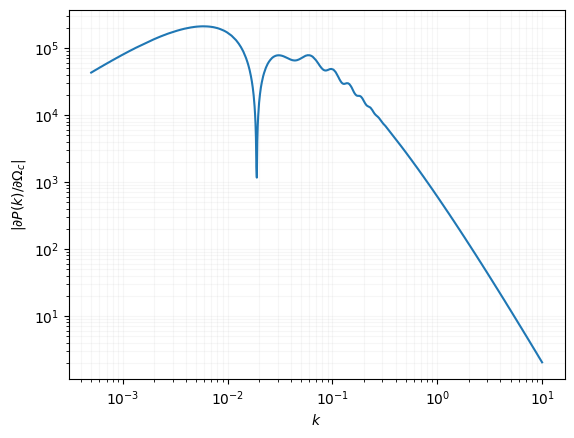

In [28]:
plt.loglog(kvals,jnp.abs(dPk_allks(Omega_c)))
plt.grid(which = 'both',alpha=0.1)
_ = plt.xlabel("$k$")
_ = plt.ylabel(r"$|\partial P(k)/\partial \Omega_c|$")